**Reference**

1. https://github.com/Kuhlman-Lab/ThermoMPNN

2. ColabFold v1.5.5: AlphaFold2 using MMseqs2. For more details, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) .


# ThermoMPNN and input data

In [1]:
%%capture
#@title #  Set up **ThermoMPNN**
#Import ThermoMPNN and its dependencies to this session. This may take a minute or two.

#You only need to do this once *per session*. To re-run ThermoMPNN on a new protein, you may start on next step.

# cleaning out any remaining data
!rm -rf /content/ThermoMPNN
!rm -rf /content/sample_data
!rm /content/*.pdb
!rm /content/*.csv

# import ThermoMPNN github repo
import os
if not os.path.exists("/content/ThermoMPNN"):
  ! git clone https://github.com/majiangqin/ThermoMPNN.git
  %cd /content/ThermoMPNN

# downloading various dependencies

! pip install omegaconf wandb pytorch-lightning biopython nglview

**The PDB file**

The PDB file itself contains detailed 3D structural data about a protein, including the coordinates of each atom within the protein molecule.

A PDB file typically starts with a header that gives an overview of the type of molecule, the method used for structure determination (such as X-ray crystallography or NMR spectroscopy), and other relevant biological and experimental details. Following this, the main body of a PDB file consists of lines that begin with record names such as ATOM, HETATM, SEQRES, HELIX, and SHEET, among others. Each ATOM line describes the coordinates of an atom within the protein structure.

HEADER gives a general description of the molecule.

TITLE provides the title of the structure.

ATOM records provide atom coordinates, with each line detailing:

The atom serial number.

The atom name (e.g., N for nitrogen, CA for alpha carbon).

The residue name (e.g., GLY for glycine).

The chain identifier.

The residue sequence number. Residue sequence numbers allow for the identification of the position of each amino acid in the primary structure of the protein.

The x, y, and z coordinates in angstroms.

The occupancy and temperature factor.

The element symbol.

The TER record indicates the end of a chain or a molecule, and END marks the end of the PDB file.

In [2]:
#@title Download PDB files
from google.colab import files
import os
import sys
from urllib import request
from urllib.error import HTTPError

# Function to download a single PDB file
def download_pdb(pdbcode, datadir, downloadurl="https://files.rcsb.org/download/"):
    """
    Downloads a PDB file from the Internet and saves it in a data directory.
    :param pdbcode: The standard PDB ID, e.g., '3ICB' or '3icb'.
    :param datadir: The directory where the downloaded file will be saved.
    :param downloadurl: The base URL for downloading PDB files.
    :return: The full path to the downloaded PDB file, or None if an error occurred.
    """
    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        request.urlretrieve(url, outfnm)
        print(f"Downloaded {pdbfn}")
        return outfnm
    except Exception as err:
        print(f"Error downloading {pdbcode}: {err}", file=sys.stderr)
        return None

# Used in final UI
# UPDATE ME
pdb_codes = ['1APS', '2LZM', '3TGL', '5AZU', '6TQ3', '6BQG', '5TR5', '4JZ4', '2A36', '1AAR', '3D2A', '2RN2']

# Create a directory for PDB files if it doesn't exist
pdb_dir = "/content/pdb_files"
os.makedirs(pdb_dir, exist_ok=True)

# Loop through each PDB code and download the file
for pdb_code in pdb_codes:
    download_pdb(pdb_code, pdb_dir)

Downloaded 1APS.pdb
Downloaded 2LZM.pdb
Downloaded 3TGL.pdb
Downloaded 5AZU.pdb
Downloaded 6TQ3.pdb
Downloaded 6BQG.pdb
Downloaded 5TR5.pdb
Downloaded 4JZ4.pdb
Downloaded 2A36.pdb
Downloaded 1AAR.pdb
Downloaded 3D2A.pdb
Downloaded 2RN2.pdb


In [3]:
import torch
import sys
import numpy as np
from dataclasses import dataclass
from Bio.PDB import PDBParser

sys.path.append('/content/ThermoMPNN')
from train_thermompnn import TransferModelPL
from omegaconf import OmegaConf

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
#@title # **Run ThermoMPNN**

#Enable multi-chain inference?
Enable = False
#NOTE: This setting has not been validated and may encounter some parsing/memory errors for large proteins.

# ---------- PDB Parsing and Dataset Creation ---------- #
import torch
import sys
import numpy as np
from dataclasses import dataclass
from Bio.PDB import PDBParser

sys.path.append('/content/ThermoMPNN')
from train_thermompnn import TransferModelPL
from omegaconf import OmegaConf


def get_chains(pdb):
  # collect list of chains in PDB to match with input
  parser = PDBParser(QUIET=True)
  structure = parser.get_structure('', pdb)
  chains = [c.id for c in structure.get_chains()]
  return chains

# # use input_chain_list to grab correct protein chain
# Chain = Chain.strip()

# if len(Chain) < 1:
#   chain_list = [get_chains(pdb_file)[0]]
#   Chain = chain_list[0]
#   print(f'Using ThermoMPNN model {Model} to predict stability across chains: {chain_list}')
# else:
#   chain_list = [Chain]
#   pdb_chains = get_chains(pdb_file)
#   assert Chain in pdb_chains, f"Chain {Chain} not found in PDB file with chains {pdb_chains}"

# # remove cys from alphabet if needed
# #  cysteine (denoted by the letter 'C')
# if Include:
#   alphabet = 'ACDEFGHIKLMNPQRSTVWY'
# else: # skip cys mutations
#   alphabet = 'ADEFGHIKLMNPQRSTVWY'


@dataclass
class Mutation:
    position: int
    wildtype: str
    mutation: str
    pdb: str

# Defines a function to generate a list of possible single-site mutations for a protein based on its sequence and residue list.
def ssm_mutation(pdb):
  # make mutation list for SSM run
  mutation_list = []
  for r in pdb['resn_list']:
    seq_pos = pdb['resn_list'].index(r)
    wtAA = pdb['seq'][seq_pos]
    if wtAA == '-':  # add missing residues to space out list
      pdb['resn_list'].insert(pdb['resn_list'].index(r), '-')

  for r in pdb['resn_list']:
    seq_pos = pdb['resn_list'].index(r)
    wtAA = pdb['seq'][seq_pos]
    if wtAA != '-':
      for mutAA in alphabet:
        mutation_list.append(wtAA + r + mutAA)

  return mutation_list


def alt_parse_PDB_biounits(x, atoms=['N', 'CA', 'C'], chain=None):
    '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (xyz_coords, sequence, residue_numbers )
   these outputs provide a set of data about the protein structure:
   the spatial coordinates of its backbone atoms (xyz_coords), its amino acid sequence (sequence),
   and the identifiers of its residues (residue_numbers).
  '''

    alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
    states = len(alpha_1)
    alpha_3 = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'GAP']

    aa_1_N = {a: n for n, a in enumerate(alpha_1)}
    aa_3_N = {a: n for n, a in enumerate(alpha_3)}
    aa_N_1 = {n: a for n, a in enumerate(alpha_1)}
    aa_1_3 = {a: b for a, b in zip(alpha_1, alpha_3)}
    aa_3_1 = {b: a for a, b in zip(alpha_1, alpha_3)}

    def AA_to_N(x):
        # ["ARND"] -> [[0,1,2,3]]
        x = np.array(x);
        if x.ndim == 0: x = x[None]
        return [[aa_1_N.get(a, states - 1) for a in y] for y in x]

    def N_to_AA(x):
        # [[0,1,2,3]] -> ["ARND"]
        x = np.array(x);
        if x.ndim == 1: x = x[None]
        return ["".join([aa_N_1.get(a, "-") for a in y]) for y in x]

    xyz, seq, min_resn, max_resn = {}, {}, 1e6, -1e6
    resn_list = []
    for line in open(x, "rb"):
        line = line.decode("utf-8", "ignore").rstrip()

        # handling MSE and SEC residues
        if line[:6] == "HETATM" and line[17:17 + 3] == "MSE":
            line = line.replace("HETATM", "ATOM  ")
            line = line.replace("MSE", "MET")
        elif line[17:17 + 3] == "MSE":
            line = line.replace("MSE", "MET")
        elif line[17:17 + 3] == "SEC":
            line = line.replace("SEC", "CYS")

        if line[:4] == "ATOM":
            ch = line[21:22]
            if ch == chain or chain is None:
                atom = line[12:12 + 4].strip()
                resi = line[17:17 + 3]
                resn = line[22:22 + 5].strip()

                # RAW resn is defined HERE
                if resn not in resn_list:
                  resn_list.append(resn) # NEED to keep ins code here
                x, y, z = [float(line[i:(i + 8)]) for i in [30, 38, 46]]
                if resn[-1].isalpha():
                    resa, resn = resn[-1], int(resn[:-1]) - 1
                else:
                    resa, resn = "", int(resn) - 1
                if resn < min_resn:
                    min_resn = resn
                if resn > max_resn:
                    max_resn = resn
                if resn not in xyz:
                    xyz[resn] = {}
                if resa not in xyz[resn]:
                    xyz[resn][resa] = {}
                if resn not in seq:
                    seq[resn] = {}
                if resa not in seq[resn]:
                    seq[resn][resa] = resi

                if atom not in xyz[resn][resa]:
                    xyz[resn][resa][atom] = np.array([x, y, z])
                # print(resn_list)

    # convert to numpy arrays, fill in missing values
    seq_, xyz_ = [], []
    # print(seq)
    try:
        for resn in range(min_resn, max_resn + 1):
            if resn in seq:
              # CLEANED resn is defined HERE
                # resn_list.append(str(resn + 1))
                # print(resn)
                for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k], 20))
            else:
                seq_.append(20)

            if resn in xyz:
                for k in sorted(xyz[resn]):
                    for atom in atoms:
                        if atom in xyz[resn][k]:
                            xyz_.append(xyz[resn][k][atom])
                        else:
                            xyz_.append(np.full(3, np.nan))
            else:
                for atom in atoms: xyz_.append(np.full(3, np.nan))
        return np.array(xyz_).reshape(-1, len(atoms), 3), N_to_AA(np.array(seq_)), list(dict.fromkeys(resn_list))
    except TypeError:
        return 'no_chain', 'no_chain', 'no_chain'


def alt_parse_PDB(path_to_pdb, input_chain_list=None, ca_only=False, side_chains=False, mut_chain=None):
  # The function returns a list of dictionaries (pdb_dict_list), where each dictionary contains parsed data
  # for a single PDB file but potentially multiple chains, depending on the input parameters.
    c = 0
    pdb_dict_list = []
    init_alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                     'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
                     'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    extra_alphabet = [str(item) for item in list(np.arange(300))]
    chain_alphabet = init_alphabet + extra_alphabet

    if input_chain_list:
        chain_alphabet = input_chain_list

    biounit_names = [path_to_pdb]
    for biounit in biounit_names:
        my_dict = {}
        s = 0
        concat_seq = ''
        concat_N = []
        concat_CA = []
        concat_C = []
        concat_O = []
        concat_mask = []
        coords_dict = {}
        for letter in chain_alphabet:
            if ca_only:
                sidechain_atoms = ['CA']
            elif side_chains:
                sidechain_atoms = ["N", "CA", "C", "O", "CB",
                                   "CG", "CG1", "OG1", "OG2", "CG2", "OG", "SG",
                                   "CD", "SD", "CD1", "ND1", "CD2", "OD1", "OD2", "ND2",
                                   "CE", "CE1", "NE1", "OE1", "NE2", "OE2", "NE", "CE2", "CE3",
                                   "NZ", "CZ", "CZ2", "CZ3", "CH2", "OH", "NH1", "NH2"]
            else:
                sidechain_atoms = ['N', 'CA', 'C', 'O']
            xyz, seq, resn_list = alt_parse_PDB_biounits(biounit, atoms=sidechain_atoms, chain=letter)
            if mut_chain is not None:
              if resn_list != 'no_chain' and letter == mut_chain:
                  my_dict['resn_list'] = list(resn_list)
            if type(xyz) != str:
                concat_seq += seq[0]
                my_dict['seq_chain_' + letter] = seq[0]
                coords_dict_chain = {}
                if ca_only:
                    coords_dict_chain['CA_chain_' + letter] = xyz.tolist()
                elif side_chains:
                    coords_dict_chain['SG_chain_' + letter] = xyz[:, 11].tolist()
                else:
                    coords_dict_chain['N_chain_' + letter] = xyz[:, 0, :].tolist()
                    coords_dict_chain['CA_chain_' + letter] = xyz[:, 1, :].tolist()
                    coords_dict_chain['C_chain_' + letter] = xyz[:, 2, :].tolist()
                    coords_dict_chain['O_chain_' + letter] = xyz[:, 3, :].tolist()
                my_dict['coords_chain_' + letter] = coords_dict_chain
                s += 1

        fi = biounit.rfind("/")
        if mut_chain is None:
          my_dict['resn_list'] = list(resn_list)
        my_dict['name'] = biounit[(fi + 1):-4]
        my_dict['num_of_chains'] = s
        my_dict['seq'] = concat_seq
        # my_dict['resn_list'] = list(resn_list)
        if s <= len(chain_alphabet):
            pdb_dict_list.append(my_dict)
            c += 1
    return pdb_dict_list

# # parse PDB file with residue number retrieval enabled
# if Enable:  # multi-chain inference requires retrieving all chains for predictions
#   pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=get_chains(pdb_file), mut_chain=Chain)
# else:
#   pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=chain_list)

# num_total_res = len(pdb_dict[0]['seq'])
# pred_res = len(pdb_dict[0][f'seq_chain_{Chain}'])

# print(f'Loaded {num_total_res} residues for inference, including {pred_res} in the selected chain.')

# mutation_list = ssm_mutation(pdb_dict[0])
# final_mutation_list = []
# for n, m in enumerate(mutation_list):
#   m = m.strip()  # clear whitespace
#   wtAA, position, mutAA = str(m[0]), str(m[1:-1]), str(m[-1])

#   assert position in pdb_dict[0]['resn_list'], f'Position {position} cannot be found in PDB file, please check inputs!'
#   pdb_position = pdb_dict[0]['resn_list'].index(position)
#   pdb_wtAA = pdb_dict[0]['seq'][pdb_position]
#   assert pdb_wtAA == wtAA, f'Position {position}{wtAA} does not match position {position}{pdb_wtAA} in PDB file, please check inputs!'
#   # assert wtAA in alphabet, f"Wild type residue {wtAA} invalid, please try again with one of the following options: {alphabet}"
#   # assert mutAA in alphabet, f"Wild type residue {mutAA} invalid, please try again with one of the following options: {alphabet}"

#   mutation_obj = Mutation(pdb_position, pdb_wtAA, mutAA, PDB)
#   final_mutation_list.append(mutation_obj)

# print('Successfully validated %s mutations for PDB %s' % (str(n + 1), PDB))

# # ---------- Model Loading ------------- #


# # general cfg for model loading
# cfg = {
#     'training': {
#         'num_workers': 8,
#         'learn_rate': 0.001,
#         'epochs': 100,
#         'lr_schedule': True,
#     },
#     'model': {
#         'hidden_dims': [64, 32],
#         'subtract_mut': True,
#         'num_final_layers': 2,
#         'freeze_weights': True,
#         'load_pretrained': True,
#         'lightattn': True,
#         'lr_schedule': True,
#     },
#     'platform': {
#         'accel': 'gpu',
#         'thermompnn_dir': '/content/ThermoMPNN/'
#     }
# }

# conf = OmegaConf.create(cfg)

# if Model == 'ThermoMPNN (standard)':
#   checkpoint = '/content/ThermoMPNN/models/thermoMPNN_default.pt'
# else:  # for now, only one model available
#   checkpoint = '/content/ThermoMPNN/models/thermoMPNN_default.pt'

# model = TransferModelPL.load_from_checkpoint(checkpoint, cfg=conf).model

# # ---------- Inference -------- #

# # enumerate through dataset and collect predictions
# torch.manual_seed(0)

# model.eval()

# with torch.no_grad():
#   predictions, _ = model(pdb_dict, final_mutation_list)
# ddG_list = []

# print(f'Successfully processed {len(predictions)} predictions for PDB {PDB} using model: {Model}')

# for p in predictions:
#   ddG_list.append(p["ddG"].item())

In [5]:
from google.colab import drive
drive.mount('/content/drive')
filepath='/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_plots'

Mounted at /content/drive


## Create predicted ddG matrix

In [ ]:
Chain = 'A'
PDB = ''
Model = 'ThermoMPNN (standard)'
Include=True

results = {}  # Dictionary to store ddG_list for each PDB
pdb_dicts = {}  # Dict to store original chain

for PDB in pdb_codes:
    # Step 1: Download PDB file
    pdb_file = download_pdb(PDB, "/content/")
    if pdb_file is None:
        print(f"Failed to download or process {PDB}, skipping...")
        continue

    # Step 2:
      # use input_chain_list to grab correct protein chain
    Chain = Chain.strip()

    if len(Chain) < 1:
      chain_list = [get_chains(pdb_file)[0]]
      Chain = chain_list[0]
      print(f'Using ThermoMPNN model {Model} to predict stability across chains: {chain_list}')
    else:
      chain_list = [Chain]
      pdb_chains = get_chains(pdb_file)
      assert Chain in pdb_chains, f"Chain {Chain} not found in PDB file with chains {pdb_chains}"

# remove cys from alphabet if needed
#  cysteine (denoted by the letter 'C')
    if Include:
      alphabet = 'ACDEFGHIKLMNPQRSTVWY'
    else: # skip cys mutations
      alphabet = 'ADEFGHIKLMNPQRSTVWY'
      pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=[get_chains(pdb_file)[0]])

    # Step 3: parse PDB file with residue number retrieval enabled
    if Enable:  # multi-chain inference requires retrieving all chains for predictions
      pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=get_chains(pdb_file), mut_chain=Chain)
    else:
      pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=chain_list)

    num_total_res = len(pdb_dict[0]['seq'])
    pred_res = len(pdb_dict[0][f'seq_chain_{Chain}'])

    print(f'Loaded {num_total_res} residues for inference, including {pred_res} in the selected chain.')

    mutation_list = ssm_mutation(pdb_dict[0])
    final_mutation_list = []
    for n, m in enumerate(mutation_list):
      m = m.strip()  # clear whitespace
      wtAA, position, mutAA = str(m[0]), str(m[1:-1]), str(m[-1])

      assert position in pdb_dict[0]['resn_list'], f'Position {position} cannot be found in PDB file, please check inputs!'
      pdb_position = pdb_dict[0]['resn_list'].index(position)
      pdb_wtAA = pdb_dict[0]['seq'][pdb_position]
      assert pdb_wtAA == wtAA, f'Position {position}{wtAA} does not match position {position}{pdb_wtAA} in PDB file, please check inputs!'
  # assert wtAA in alphabet, f"Wild type residue {wtAA} invalid, please try again with one of the following options: {alphabet}"
  # assert mutAA in alphabet, f"Wild type residue {mutAA} invalid, please try again with one of the following options: {alphabet}"

      mutation_obj = Mutation(pdb_position, pdb_wtAA, mutAA, PDB)
      final_mutation_list.append(mutation_obj)

    print('Successfully validated %s mutations for PDB %s' % (str(n + 1), PDB))

# Step 4:---------- Model Loading ------------- #


# general cfg for model loading
    cfg = {
         'training': {
        'num_workers': 8,
        'learn_rate': 0.001,
        'epochs': 100,
        'lr_schedule': True,
       },
      'model': {
        'hidden_dims': [64, 32],
        'subtract_mut': True,
        'num_final_layers': 2,
        'freeze_weights': True,
        'load_pretrained': True,
        'lightattn': True,
        'lr_schedule': True,
      },
     'platform': {
        'accel': 'gpu',
        'thermompnn_dir': '/content/ThermoMPNN/'
    }
    }

    conf = OmegaConf.create(cfg)

    if Model == 'ThermoMPNN (standard)':
      checkpoint = '/content/ThermoMPNN/models/thermoMPNN_default.pt'
    else:  # for now, only one model available
      checkpoint = '/content/ThermoMPNN/models/thermoMPNN_default.pt'

    model = TransferModelPL.load_from_checkpoint(checkpoint, cfg=conf).model

# ---------- Inference -------- #

# enumerate through dataset and collect predictions
    torch.manual_seed(0)

    model.eval()

    with torch.no_grad():
      predictions, _ = model(pdb_dict, final_mutation_list)
    ddG_list = []

    print(f'Successfully processed {len(predictions)} predictions for PDB {PDB} using model: {Model}')

    for p in predictions:
      ddG_list.append(p["ddG"].item())

    # Step 5: post processing
    results[PDB] = ddG_list
     ### NOTE: run this cell even if all options are disabled!


 ### Explicitly penalize disulfide breakage (recommended)?
    Penalize = True

    import pandas as pd
    df = pd.DataFrame({'Mutation': mutation_list, 'ddG (kcal/mol)': ddG_list})
    df['ddG (kcal/mol)'] = df['ddG (kcal/mol)'].round(4)

    df['pos'] = df['Mutation'].str[1:-1]
    df['wtAA'] = df['Mutation'].str[0]
    df['mutAA'] = df['Mutation'].str[-1]

    if Penalize:
  # re-load PDB with side chains enabled
      if Enable:  # multi-chain inference requires retrieving all chains for predictions
        pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=get_chains(pdb_file), mut_chain=Chain, side_chains=True)
      else:
       pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=chain_list, side_chains=True)

  # collect all SG coordinates from all chains
      coords_all = [k for k in pdb_dict[0].keys() if k.startswith('coords')]
      chains = [c[-1] for c in coords_all]
      sg_coords = [pdb_dict[0][c][f'SG_chain_{chain}'] for c, chain in zip(coords_all, chains)]
      sg_coords = np.concatenate(sg_coords, axis=0)

  # calculate pairwise distance and threshold to find disulfides
      from scipy.spatial.distance import cdist
      dist = cdist(sg_coords, sg_coords)
      dist = np.nan_to_num(dist, 10000)
      hits = np.where((dist < 3) & (dist > 0)) # tuple of two [N] arrays of indices


  # match hit indices to actual resns for penalty
      all_resns = pdb_dict[0]['resn_list']
      bad_resns = []
      for h in hits[0]:
       bad_resns.append(all_resns[h])

      print('Identified the following disulfide engaged residues:', bad_resns)

  # apply penalty
      penalty = 2  # in kcal/mol - higher is less stable
      mask = df['pos'].isin(bad_resns) & (df['wtAA'] != df['mutAA'])

      df.loc[mask, 'ddG (kcal/mol)'] = df.loc[mask, 'ddG (kcal/mol)'] + penalty

    # step 6: Plot Output Data
    import seaborn as sns
    import matplotlib.pyplot as plt

    positions = df['pos'].unique()
    arr = np.zeros((positions.size, len(alphabet)), dtype=float)
    for p_idx, p in enumerate(positions):
        for a_idx, a in enumerate(alphabet):
          arr[p_idx, a_idx] = df.loc[(df['pos'] == p) & (df['mutAA'] == a)]['ddG (kcal/mol)']
    print('df: \n',df)
    df.to_csv(f'{filepath}/{PDB}.csv')
    sns.set()
    sns.set(rc={"figure.figsize": (positions.size // 4, 5)})
    g = sns.heatmap(data=arr.T, cmap='RdBu_r', center=0, robust=True,
            xticklabels=positions, yticklabels=alphabet,
            vmin=-3, vmax=3, linewidth=0.5, cbar_kws={'label': 'ddG (kcal/mol)'})
    g.set(xlabel='Position', ylabel='Amino Acid', title='SSM Thermostability Profile');
    plt.yticks(rotation=0, ha='right');
    plt.subplots_adjust(bottom=0.2)
    plt.savefig(f'{filepath}/{PDB}.png')
    # plt.show()
    plt.close()




## Visualize predicted ddG matrix

In [ ]:
!pip install d3blocks
!pip install clusteval

import pandas as pd
import numpy as np
from google.colab import files, drive
import os
import sys
from urllib import request
from urllib.error import HTTPError
from d3blocks import D3Blocks

drive.mount('/content/drive')
filepath='/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_plots'
savepath = '/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_matrices'

pdb_codes= ['1APS', '2LZM', '3TGL', '5AZU', '6TQ3', '6BQG', '5TR5', '4JZ4', '2A36', '1AAR', '3D2A', '2RN2']

alphabet = 'ACDEFGHIKLMNPQRSTVWY'

In [33]:
# Save all stuff
for pdb in pdb_codes:

    df_orig = pd.read_csv(os.path.join(filepath, f'{pdb}.csv'), index_col=None)

    cols_to_keep = ['wtAA', 'mutAA', 'ddG (kcal/mol)']
    renamed_cols = ['weight', 'source', 'target']
    df = pd.read_csv(os.path.join(filepath, f'{pdb}.csv'), usecols=cols_to_keep, header=0, index_col=None)
    df.columns = renamed_cols
    df = df[['source', 'target', 'weight']]

    # Replace AAs with ints
    len_seq = int(len(df)/20)
    new_source = []
    new_target = []
    for i in range(1, len_seq+1):
        new_source.extend([i]*20)
        new_target.extend(range(1,21))
    df_int = pd.DataFrame({'source': new_source, 'target': new_target, 'weight': df['weight']})

    # Create matrix
    res_mat = np.array(df['weight']).reshape(-1,20).T  # weights matrix - (substitute AAs x WT indices)
    wt = [el for ix,el in enumerate(df['source']) if (ix) % 20 == 0]  # get WT AAs for chosen PDB
    res_df = pd.DataFrame(res_mat)#, columns=wt)  # convert to df
    res_df['AA_sub'] = [el for el in alphabet]  # set substitution AAs as the index
    res_df.set_index('AA_sub', inplace=True)
    res_df.index.name = None


    # Initialize
    d3 = D3Blocks()

    cmap = 'interpolateMagma'
    short_dim = 450

    # Save matrix
    d3.matrix(
        res_df,
        cmap=cmap,
        figsize=[res_mat.shape[1]*20, short_dim],
        filepath=os.path.join(savepath, f'{pdb}_matrix.html')
    )

    # Save matrix transpose
    d3.matrix(
        res_df.transpose(),
        cmap=cmap,
        figsize=[short_dim, res_mat.shape[1]*10],
        filepath=os.path.join(savepath, f'{pdb}_matrix_T.html')
    )

    # Save fixed data
    dfj = df.copy()
    dfj.columns = ['group', 'variable', 'value']

    # Group needs to be a non-repeating value
    group = []
    for i in range(len(dfj) // 20):
        group.extend([str(i+1)]*20)
    dfj['group'] = group

    dfj['value'] = dfj['value'].astype(str)
    dfj.to_json(os.path.join(savepath, f'{pdb}.json'), orient='records')

    # Transpose - display tall matrix instead of wide
    dfj_T = dfj.copy()
    dfj_T['group'] = dfj['variable']
    dfj_T['variable'] = dfj['group']

    dfj_T.to_json(os.path.join(savepath, f'{pdb}_T.json'), orient='records')


    # Save actual min/max to txt file for adjustments
    max_ = max([float(el) for el in dfj['value']])
    min_ = min([float(el) for el in dfj['value']])
    pos_min = min([float(el) for el in dfj['value'] if float(el) > 0])
    with open(os.path.join(savepath, f'{pdb}_info.txt'), 'w') as f:
        f.write(f'min ddG: {min_}\n')
        f.write(f'max ddG: {max_}')

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Matrix]
[d3blocks] >INFO> filepath is set to [/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_matrices/1APS_matrix.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Open browser: /content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_matrices/1APS_matrix.html
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Matrix]
[d3blocks] >INFO> filepath is set to [/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_matrices/1APS_matrix_T.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Open browser: /content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_matrices/1APS_matrix_T.html
[d3blocks] >INFO> Cleaning edge_properties and config param

In [ ]:
# #@title # Post-processing

#  ### NOTE: run this cell even if all options are disabled!


#  ### Explicitly penalize disulfide breakage (recommended)?
# Penalize = True

# import pandas as pd
# df = pd.DataFrame({'Mutation': mutation_list, 'ddG (kcal/mol)': ddG_list})
# df['ddG (kcal/mol)'] = df['ddG (kcal/mol)'].round(4)

# df['pos'] = df['Mutation'].str[1:-1]
# df['wtAA'] = df['Mutation'].str[0]
# df['mutAA'] = df['Mutation'].str[-1]

# if Penalize:
#   # re-load PDB with side chains enabled
#   if Enable:  # multi-chain inference requires retrieving all chains for predictions
#     pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=get_chains(pdb_file), mut_chain=Chain, side_chains=True)
#   else:
#     pdb_dict = alt_parse_PDB(path_to_pdb=pdb_file, input_chain_list=chain_list, side_chains=True)

#   # collect all SG coordinates from all chains
#   coords_all = [k for k in pdb_dict[0].keys() if k.startswith('coords')]
#   chains = [c[-1] for c in coords_all]
#   sg_coords = [pdb_dict[0][c][f'SG_chain_{chain}'] for c, chain in zip(coords_all, chains)]
#   sg_coords = np.concatenate(sg_coords, axis=0)

#   # calculate pairwise distance and threshold to find disulfides
#   from scipy.spatial.distance import cdist
#   dist = cdist(sg_coords, sg_coords)
#   dist = np.nan_to_num(dist, 10000)
#   hits = np.where((dist < 3) & (dist > 0)) # tuple of two [N] arrays of indices


#   # match hit indices to actual resns for penalty
#   all_resns = pdb_dict[0]['resn_list']
#   bad_resns = []
#   for h in hits[0]:
#     bad_resns.append(all_resns[h])

#   print('Identified the following disulfide engaged residues:', bad_resns)

#   # apply penalty
#   penalty = 2  # in kcal/mol - higher is less stable
#   mask = df['pos'].isin(bad_resns) & (df['wtAA'] != df['mutAA'])

#   df.loc[mask, 'ddG (kcal/mol)'] = df.loc[mask, 'ddG (kcal/mol)'] + penalty



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# filepath='/content/drive/My Drive/Colab Notebooks/'


In [ ]:
# #@title  **Plot Output Data**

# #### Remember, higher ddG means less stable, lower ddG means more stable.

# import seaborn as sns
# import matplotlib.pyplot as plt

# positions = df['pos'].unique()
# arr = np.zeros((positions.size, len(alphabet)), dtype=float)
# for p_idx, p in enumerate(positions):
#   for a_idx, a in enumerate(alphabet):
#     arr[p_idx, a_idx] = df.loc[(df['pos'] == p) & (df['mutAA'] == a)]['ddG (kcal/mol)']

# sns.set()
# sns.set(rc={"figure.figsize": (positions.size // 4, 5)})
# g = sns.heatmap(data=arr.T, cmap='RdBu_r', center=0, robust=True,
#             xticklabels=positions, yticklabels=alphabet,
#             vmin=-3, vmax=3, linewidth=0.5, cbar_kws={'label': 'ddG (kcal/mol)'})
# g.set(xlabel='Position', ylabel='Amino Acid', title='SSM Thermostability Profile');
# plt.yticks(rotation=0, ha='right');
# plt.savefig(f'{filepath}ssm.png')

In the context of single-site mutagenesis (SSM), y axis allows you to see the predicted effects of mutating the wild-type amino acid at a specific position to each of the other possible amino acids. For instance, if you're looking at the row for 'A' (Alanine), you're looking at the predicted stability changes (ddG values) for mutations where the original amino acid at each position is changed to Alanine.

The color intensity in each cell of the heatmap shows the magnitude of the effect on protein stability for that particular mutation, with the scale provided by the color bar on the right. Cool colors (e.g., blue) typically indicate stabilizing mutations that increase protein stability (negative ddG), while warm colors (e.g., red) indicate destabilizing mutations that decrease stability (positive ddG).


different PDB files representing different proteins or different mutants of the same protein will result in different thermostability profiles, as reflected in such a heatmap.

Here’s how to interpret this type of heatmap:

Amino Acid Rows (Y-axis): Each row corresponds to one of the 20 standard amino acids (plus any special characters, like stop codons or gaps, if included). This is the potential amino acid to which the native residue can be mutated.

Position Columns (X-axis): Each column represents a position in the protein sequence where mutations are considered. These are specific spots in the protein's structure where amino acid changes might affect the protein's function or stability.

Color Coding: The colors indicate the predicted change in protein stability (ΔΔG) upon mutation:

Red: A higher ΔΔG value, indicating that the mutation is predicted to decrease protein stability (destabilizing mutation).

Blue: A lower (negative) ΔΔG value, suggesting that the mutation could increase stability (stabilizing mutation).

White or Pale Colors: ΔΔG values close to zero, indicating little to no effect on stability.

Interpreting Patterns:

Dark Red Squares: If you see a position with many dark red squares (e.g., many different amino acid changes all result in high positive ΔΔG), this suggests that the native residue is important for stability and that it is sensitive to substitution.

Dark Blue Squares: Conversely, if you see dark blue squares, these are potential stabilizing mutations. However, these should be interpreted with caution, as some might be structurally or functionally disruptive despite being 'stabilizing' in terms of energy.

Rows or Columns with Varying Colors: Variation in a row suggests that the specific amino acid replacement varies in its effect depending on where it occurs in the protein. Variation across a column suggests that the specific position has different sensitivities to various amino acid replacements.
Biological Context: To fully interpret the heatmap, you should consider the biological context of the mutations. For instance, mutations in active sites, binding interfaces, or structurally critical regions may have functional consequences that aren't directly related to the simplistic measure of thermodynamic stability.

When you switch to a different PDB file, the protein sequence—hence, the specific positions—and possibly the folding and stability landscape will change. Therefore, the heatmap for another PDB file will reflect the mutational effects pertinent to that new structure's specific amino acid sequence and 3D conformation.

Key Features of Annexin V (1APS):

Biological Role: Annexin V is involved in the anticoagulant protein complex and plays a role in the inhibition of blood coagulation by competing for phospholipid binding sites with procoagulant proteins. It is also used in biological research and medical diagnostics as a marker for apoptosis due to its affinity for phosphatidylserine.

Structure: The crystal structure of Annexin V can provide insights into its binding interactions with phospholipids and its mechanism of action in cellular processes.

Usage in Research and Medicine: Due to its phospholipid binding properties, fluorescently labeled Annexin V is commonly used in flow cytometry and other assays to identify apoptotic cells.

One protein that is commonly used as a benchmark is T4 lysozyme (PDB code "2LZM"). It's a well-studied enzyme, and a lot of mutational data is available for it, which makes it a great candidate for ΔΔG prediction.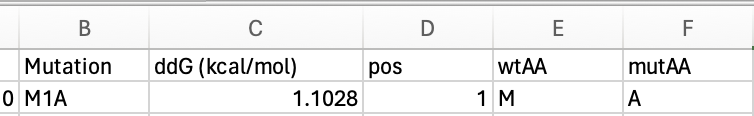

In [ ]:
!pip install py3Dmol



The choice between using RCSB PDB structures and AlphaFold predictions depends on the context of your research. If high-quality experimental data is available, it typically takes precedence due to its accuracy and reliability. However, AlphaFold's predictions can be an invaluable resource for proteins lacking experimental structures, for hypothesis generation, and for complementing existing structural data. In many cases, leveraging both sources of information may offer the most comprehensive insights into protein function and biology.

#AlphaFold2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath='/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/pdb_plots'

Mounted at /content/drive


In [ ]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.9 MB/s eta 0:00:00


In [ ]:
#@title Parse the PDB file
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1

to_update = '3TGL'  # CHANGE ME

pdb_file_path = f'/content/pdb_files/{to_update}.pdb'

# Create a PDB parser
parser = PDBParser()

# Parse the PDB file
structure = parser.get_structure('PDB_structure', pdb_file_path)

for model in structure:
    for chain in model:
        sequence = ''
        for residue in chain:
            # Check if the residue is a standard amino acid
            # BioPython uses 'X' for unknown or non-standard amino acids
            if residue.get_resname() in ['ALA', 'CYS', 'ASP', 'GLU', 'PHE',
                                         'GLY', 'HIS', 'ILE', 'LYS', 'LEU',
                                         'MET', 'ASN', 'PRO', 'GLN', 'ARG',
                                         'SER', 'THR', 'VAL', 'TRP', 'TYR']:
                sequence += seq1(residue.get_resname())
        print(f"Chain {chain.id}: {sequence}")


Chain A: GIRAATSQEINELTYYTTLSANSYCRTVIPGATWDCIHCDATEDLKIIKTWSTLIYDTNAMVARGDSEKTIYIVFRGSSSIRNWIADLTFVPVSYPPVSGTKVHKGFLDSYGEVQNELVATVLDQFKQYPSYKVAVTGHSLGGATVLLCALDLYQREEGLSSSNLFLYTQGQPRVGDPAFANYVVSTGIPYRRTVNERDIVPHLPPAAFGFLHAGEEYWITDNSPETVQVCTSDLETSDCSNSIVPFTSVLDHLSYFGINTGLCT


In [ ]:
sequence

'GIRAATSQEINELTYYTTLSANSYCRTVIPGATWDCIHCDATEDLKIIKTWSTLIYDTNAMVARGDSEKTIYIVFRGSSSIRNWIADLTFVPVSYPPVSGTKVHKGFLDSYGEVQNELVATVLDQFKQYPSYKVAVTGHSLGGATVLLCALDLYQREEGLSSSNLFLYTQGQPRVGDPAFANYVVSTGIPYRRTVNERDIVPHLPPAAFGFLHAGEEYWITDNSPETVQVCTSDLETSDCSNSIVPFTSVLDHLSYFGINTGLCT'

In [ ]:


pdb_id = to_update
parser = PDBParser()
structure = parser.get_structure(pdb_id, f"/content/pdb_files/{pdb_id}.pdb")

chains = [chain.id for model in structure for chain in model]
unique_chains = set(chains)
print(f"Chains in the structure: {unique_chains}")
if len(unique_chains) > 1:
    print("This is a multi-chain protein complex.")
else:
    print("This is a single-chain protein.")


Chains in the structure: {'A'}
This is a single-chain protein.


In [ ]:

def apply_mutation(sequence, wildtype, mut, occurrence):
    # find the nth occurrence of the wildtype amino acid
    pos = -1
    for _ in range(occurrence):
        pos = sequence.find(wildtype, pos + 1)
        if pos == -1:
            return None  # don't find enough occurrences

    mutated_seq = list(sequence)
    if pos != -1:
        mutated_seq[pos] = mut
    return "".join(mutated_seq)




In [ ]:
#@title Input mutation code, get mutation sequence
mutation_code = ("I", "H", 6)

mutated_sequence = apply_mutation(sequence, *mutation_code)
if mutated_sequence:
    print(f"Original sequence: {sequence}")
    print(f"Mutated  sequence: {mutated_sequence}")
else:
    print("Mutation could not be applied. Not enough occurrences of the wildtype amino acid.")



Original sequence: GIRAATSQEINELTYYTTLSANSYCRTVIPGATWDCIHCDATEDLKIIKTWSTLIYDTNAMVARGDSEKTIYIVFRGSSSIRNWIADLTFVPVSYPPVSGTKVHKGFLDSYGEVQNELVATVLDQFKQYPSYKVAVTGHSLGGATVLLCALDLYQREEGLSSSNLFLYTQGQPRVGDPAFANYVVSTGIPYRRTVNERDIVPHLPPAAFGFLHAGEEYWITDNSPETVQVCTSDLETSDCSNSIVPFTSVLDHLSYFGINTGLCT
Mutated  sequence: GIRAATSQEINELTYYTTLSANSYCRTVIPGATWDCIHCDATEDLKIHKTWSTLIYDTNAMVARGDSEKTIYIVFRGSSSIRNWIADLTFVPVSYPPVSGTKVHKGFLDSYGEVQNELVATVLDQFKQYPSYKVAVTGHSLGGATVLLCALDLYQREEGLSSSNLFLYTQGQPRVGDPAFANYVVSTGIPYRRTVNERDIVPHLPPAAFGFLHAGEEYWITDNSPETVQVCTSDLETSDCSNSIVPFTSVLDHLSYFGINTGLCT


In [ ]:
#Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = mutated_sequence #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname test_6e3fe
sequence GIRAATSQEINELTYYTTLSANSYCRTVIPGATWDCIHCDATEDLKIHKTWSTLIYDTNAMVARGDSEKTIYIVFRGSSSIRNWIADLTFVPVSYPPVSGTKVHKGFLDSYGEVQNELVATVLDQFKQYPSYKVAVTGHSLGGATVLLCALDLYQREEGLSSSNLFLYTQGQPRVGDPAFANYVVSTGIPYRRTVNERDIVPHLPPAAFGFLHAGEEYWITDNSPETVQVCTSDLETSDCSNSIVPFTSVLDHLSYFGINTGLCT
length 265


In [ ]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip install -q --no-warn-conflicts -U dm-haiku==0.0.10 jax==0.3.25")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 305 ms, sys: 42.8 ms, total: 347 ms
Wall time: 1min 1s


In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "single_sequence" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
# !l!find /content -name "*.a3m"


In [ ]:
#@title Advanced settings
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "0" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

The "5 models" referred to in the code snippet likely pertain to the different pretrained models or model versions available within the AlphaFold2 framework, specifically as integrated into the ColabFold adaptation. In the context of AlphaFold2 and ColabFold, these models represent different sets of weights trained on the same architecture but with different subsets of the training data or different training configurations. This diversity helps capture a broader range of structural features and provides a consensus approach to structure prediction by aggregating predictions from multiple models.

AlphaFold2 released five main models for monomer predictions (named model_1 to model_5) and additional models for multimer predictions. These models were trained separately to ensure robustness and accuracy, as each might capture different aspects of protein structure prediction:

In [ ]:
#@title Run Prediction
display_images = False

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
#   K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
  T4_chk = os.popen('nvidia-smi | grep "Tesla T4" | wc -l').read()
except:
#   K80_chk = "0"
  T4_chk = "0"
  pass
# if "1" in K80_chk:
if "1" in T4_chk:
#   print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  print("WARNING: found GPU Tesla T4: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    # num_models=5,
    num_models=1,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    # model_order=[1,2,3,4,5],
    model_order=[1],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

2024-03-31 11:50:58,174 Running on TPU
2024-03-31 11:51:05,228 Found 2 citations for tools or databases
2024-03-31 11:51:05,230 Query 1/1: test_6e3fe (length 265)
2024-03-31 11:52:15,602 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=30.5 pTM=0.233
2024-03-31 11:52:15,604 alphafold2_ptm_model_1_seed_000 took 30.3s (0 recycles)
2024-03-31 11:52:15,866 reranking models by 'plddt' metric
2024-03-31 11:52:15,867 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=30.5 pTM=0.233
2024-03-31 11:52:17,102 Done


0

In [ ]:
import shutil

# Grab mutated PDBs from here
af_results_dir = '/content/test_6e3fe/'
mut_pdb_file = [el for el in os.listdir(af_results_dir) if '.pdb' in el][0]
mut_pdb_path_orig = os.path.join(af_results_dir, mut_pdb_file)

# Send mutated PDBs here
mut_pdb_dir = '/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/mut_pdbs'
mut_pdb_path_final = os.path.join(mut_pdb_dir, mut_pdb_file)

# TODO: rename them

shutil.copy(mut_pdb_path_orig, mut_pdb_path_final)

'/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/mut_pdbs/test_6e3fe_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb'

In [ ]:
os.system('ls')

0

In [ ]:
os.system('cp /content/test_6e3fe/test_6e3fe_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb /content/drive/My Drive/Colab Notebooks/CSE 6242 Project/mut_pdbs/test_6e3fe_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb')

256

In [ ]:
mut_pdb_path_orig

'/content/test_6e3fe/test_6e3fe_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb'

In [ ]:

mut_pdb_path_final

'/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/mut_pdbs/test_6e3fe_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb'

In [ ]:
import os
FILE='/content/test_141fd.result.zip'
if os.path.isfile(FILE):
  print('exist')
else:
  print('not exist')

exist


In [ ]:
#@title Display wildtype 3D structure
!pip install py3Dmol -q
import py3Dmol
with open("/content/pdb_files/2LZM.pdb") as ifile:
    protein = "".join([x for x in ifile])
#view = py3Dmol.view(query='pdb:1DIV', width=800, height=600)
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1},style)
view.zoom(0.12)
view.rotate(235, {'x':0,'y':1,'z':1})
view.spin({'x':-0.2,'y':0.5,'z':1},1)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title Display 3D structure after mutation
!pip install py3Dmol -q
import py3Dmol
with open("/content/pdb_files/M1A.pdb") as ifile:
    protein = "".join([x for x in ifile])
#view = py3Dmol.view(query='pdb:1DIV', width=800, height=600)
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1},style)
view.zoom(0.12)
view.rotate(235, {'x':0,'y':1,'z':1})
view.spin({'x':-0.2,'y':0.5,'z':1},1)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
with open("/content/pdb_files/N2A.pdb") as ifile:
    protein = "".join([x for x in ifile])
#view = py3Dmol.view(query='pdb:1DIV', width=800, height=600)
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1},style)
view.zoom(0.12)
view.rotate(235, {'x':0,'y':1,'z':1})
view.spin({'x':-0.2,'y':0.5,'z':1},1)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Run Prediction (multi, one-shot)
Generate mutated protein sequence for multiple PDBs and point mutation combos

In [ ]:
###########
# Enter 1 or more PDBs and mutation codes to generate

# UPDATE ME
to_update_multi = [
    '3TGL',
    '4GWT', '4GWT', '4GWT',
    '5AZU', '5AZU', '5AZU',
    '1A7C', '1A7C', '1A7C',
    ]

# UPDATE ME
mutation_codes_multi = [
    ("R", "M", 7),
    ('K', 'A', 6), ('L', 'F', 7), ('P', 'R', 9),
    ('A', 'C', 1), ('E', 'R', 2), ('S', 'K', 4),
    ('H', 'A', 2), ('H', 'C', 2), ('P', 'Y', 4),
    ]

assert len(to_update_multi) == len(mutation_codes_multi), 'Please make sure you have specified an equal number of PDB files and mutation codes!'
###########


# INITIAL SETUP
# pdb_codes = [
#     "1A43", "1A5E", "1A7C", "1AAR", "1AG2", "1AJ3", "1AKK", "1AM7", "1ANK", "1APS",
#     "1ARR", "1AXB", "1AYF", "1AYI", "1AZP", "1B0O", "1B10", "1BFG", "1BFM", "1BNI",
#     "1BP2", "1BPI", "1BTA", "1BU4", "1BVC", "1BYW", "1C2R", "1C9O", "1CDC", "1CF3",
#     "1CHK", "1CQW", "1CSP", "1CYC", "1DIL", "1DIV", "1DKT", "1FKJ", "1FRD", "1FTG",
#     "1FXA", "1G6N", "1G6P", "1H0C", "1H0X", "1H56", "1H7M", "1HFY", "1HFZ", "1HME",
#     "1HNG", "1HTI", "1HUE", "1IGV", "1IHB", "1IMQ", "1IO2", "1IOB", "1IRO", "1ITM",
#     "1JY0", "1K5U", "1K9Q", "1KCQ", "1KFW", "1LS4", "1LZ1", "1M21", "1M7T", "1MBG",
#     "1MGR", "1MJ5", "1MJC", "1MSI", "1N18", "1N88", "1NVO", "1O1U", "1OH0", "1OIA",
#     "1ONC", "1P2P", "1PDO", "1PFL", "1POH", "1PX0", "1QGD", "1QLP", "1QM0", "1QND",
#     "1QQV", "1REI", "1RGG", "1RIL", "1RIS", "1ROP", "1RRO", "1RTB", "1RX4", "1SHF",
#     "1SHG", "1STN", "1SUP", "1TEN", "1TIT", "1TTG", "1TUP", "1TUX", "1UBQ", "1UWO",
#     "1UZC", "1VII", "1VQB", "1W4E", "1W4H", "1WIT", "1XZO", "1Y4Y", "1Y9X", "1YYJ",
#     "2A01", "2A36", "2ABD", "2AFG", "2AKY", "2BJD", "2C9Q", "2DRI", "2DVV", "2GNQ",
#     "2HBB", "2HMB", "2HPR", "2IFB", "2IN9", "2K3K", "2K7K", "2KYC", "2LTB", "2LZM",
#     "2MMX", "2MPC", "2N53", "2O9P", "2OUO", "2PTL", "2RLK", "2RN2", "2SPZ", "2TRX",
#     "2UXY", "2VY0", "2WQG", "3BLS", "3D2A", "3DVF", "3ECU", "3F6R", "3G1G", "3MBP",
#     "3PG0", "3PG4", "3S4M", "3S92", "3SSI", "3TGL", "3VUB", "3WP4", "451C", "4BJX",
#     "4GWT", "4HXJ", "4JZ4", "4LYZ", "4Q0M", "4YEE", "4YEF", "4ZLU", "5AZU", "5C0Z",
#     "5CRO", "5EMZ", "5NP8", "5T43", "5TR5", "5ZYR", "6BQG", "6G4B", "6JHM", "6TQ3"
# ]  # large

pdb_codes = ["1A43", "1A5E", "1A7C", "1AAR",'1APS','2LZM','4GWT','3TGL','5AZU','6BQG']  # small

# Download PDB files
from google.colab import files
import os
import sys
from urllib import request
from urllib.error import HTTPError

!pip install biopython

# Function to download a single PDB file
def download_pdb(pdbcode, datadir, downloadurl="https://files.rcsb.org/download/"):
    """
    Downloads a PDB file from the Internet and saves it in a data directory.
    :param pdbcode: The standard PDB ID, e.g., '3ICB' or '3icb'.
    :param datadir: The directory where the downloaded file will be saved.
    :param downloadurl: The base URL for downloading PDB files.
    :return: The full path to the downloaded PDB file, or None if an error occurred.
    """
    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        request.urlretrieve(url, outfnm)
        print(f"Downloaded {pdbfn}")
        return outfnm
    except Exception as err:
        print(f"Error downloading {pdbcode}: {err}", file=sys.stderr)
        return None

pdb_codes= ['2LZM','4GWT','3TGL','5AZU','1A7C']

# Create a directory for PDB files if it doesn't exist
pdb_dir = "/content/pdb_files"
os.makedirs(pdb_dir, exist_ok=True)

# Loop through each PDB code and download the file
for pdb_code in pdb_codes:
    download_pdb(pdb_code, pdb_dir)

# Mount drive and establish
from google.colab import drive
drive.mount('/content/drive')

# PARSE THE PDB FILE
print('PARSING PDB FILE...')
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1


for to_update, mutation_code in zip(to_update_multi, mutation_codes_multi):
    print('\n###########################################')
    print(f'PROCESSING {to_update} WITH MUTATION {mutation_code}')
    print('###########################################\n')

    pdb_file_path = f'/content/pdb_files/{to_update}.pdb'

    # Create a PDB parser
    parser = PDBParser()

    # Parse the PDB file
    structure = parser.get_structure('PDB_structure', pdb_file_path)

    for model in structure:
        for chain in model:
            sequence = ''
            for residue in chain:
                # Check if the residue is a standard amino acid
                # BioPython uses 'X' for unknown or non-standard amino acids
                if residue.get_resname() in ['ALA', 'CYS', 'ASP', 'GLU', 'PHE',
                                            'GLY', 'HIS', 'ILE', 'LYS', 'LEU',
                                            'MET', 'ASN', 'PRO', 'GLN', 'ARG',
                                            'SER', 'THR', 'VAL', 'TRP', 'TYR']:
                    sequence += seq1(residue.get_resname())
            # print(f"Chain {chain.id}: {sequence}")

    pdb_id = to_update
    parser = PDBParser()
    structure = parser.get_structure(pdb_id, f"/content/pdb_files/{pdb_id}.pdb")

    chains = [chain.id for model in structure for chain in model]
    unique_chains = set(chains)

    def apply_mutation(sequence, wildtype, mut, occurrence):
        # find the nth occurrence of the wildtype amino acid
        pos = -1
        for _ in range(occurrence):
            pos = sequence.find(wildtype, pos + 1)
            if pos == -1:
                print(f'NOT ENOUGH OCCURRENCES!! Expected {occurrence}, found {sequence.count(mut)}')
                return None  # don't find enough occurrences

        mutated_seq = list(sequence)
        if pos != -1:
            mutated_seq[pos] = mut
        return "".join(mutated_seq)

    # INPUT MUTATION CODE, GET MUTATION SEQUENCE
    print('GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...')
    mutated_sequence = apply_mutation(sequence, *mutation_code)
    if mutated_sequence:
        print(f"Original sequence: {sequence}")
        print(f"Mutated  sequence: {mutated_sequence}")
    else:
        print("Mutation could not be applied. Not enough occurrences of the wildtype amino acid.")
        continue

    #Input protein sequence(s), then hit `Runtime` -> `Run all`
    from google.colab import files
    import os
    import re
    import hashlib
    import random

    from sys import version_info
    python_version = f"{version_info.major}.{version_info.minor}"

    def add_hash(x,y):
        return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

    query_sequence = mutated_sequence
    jobname = 'test'
    # number of models to use
    num_relax = 0
    template_mode = "none"

    use_amber = num_relax > 0

    # remove whitespaces
    query_sequence = "".join(query_sequence.split())

    basejobname = "".join(jobname.split())
    basejobname = re.sub(r'\W+', '', basejobname)
    jobname = add_hash(basejobname, query_sequence)

    # check if directory with jobname exists
    def check(folder):
        if os.path.exists(folder):
            return False
        else:
            return True
    if not check(jobname):
        n = 0
        while not check(f"{jobname}_{n}"): n += 1
        jobname = f"{jobname}_{n}"

    # make directory to save results
    os.makedirs(jobname, exist_ok=True)

    # save queries
    queries_path = os.path.join(jobname, f"{jobname}.csv")
    with open(queries_path, "w") as text_file:
        text_file.write(f"id,sequence\n{jobname},{query_sequence}")

    if template_mode == "pdb100":
        use_templates = True
        custom_template_path = None
    elif template_mode == "custom":
        custom_template_path = os.path.join(jobname,f"template")
        os.makedirs(custom_template_path, exist_ok=True)
        uploaded = files.upload()
        use_templates = True
        for fn in uploaded.keys():
            os.rename(fn,os.path.join(custom_template_path,fn))
    else:
        custom_template_path = None
        use_templates = False

    print("jobname",jobname)
    print("sequence",query_sequence)
    print("length",len(query_sequence.replace(":","")))

    # INSTALL DEPENDENCIES
    print('INSTALLING SOME DEPENDENCIES...')

    import os
    USE_AMBER = use_amber
    USE_TEMPLATES = use_templates
    PYTHON_VERSION = python_version

    if not os.path.isfile("COLABFOLD_READY"):
        print("installing colabfold...")
        os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
        if os.environ.get('TPU_NAME', False) != False:
            os.system("pip install -q --no-warn-conflicts -U dm-haiku==0.0.10 jax==0.3.25")
        os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
        os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
        os.system("touch COLABFOLD_READY")

    if USE_AMBER or USE_TEMPLATES:
        if not os.path.isfile("CONDA_READY"):
            print("installing conda...")
            os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
            os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
            os.system("mamba config --set auto_update_conda false")
            os.system("touch CONDA_READY")

    if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
        print("installing hhsuite and amber...")
        os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
        os.system("touch HH_READY")
        os.system("touch AMBER_READY")
    else:
        if USE_TEMPLATES and not os.path.isfile("HH_READY"):
            print("installing hhsuite...")
            os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
            os.system("touch HH_READY")
        if USE_AMBER and not os.path.isfile("AMBER_READY"):
            print("installing amber...")
            os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
            os.system("touch AMBER_READY")

    # MSA options
    msa_mode = "single_sequence"
    pair_mode = "unpaired_paired"

    # decide which a3m to use
    if "mmseqs2" in msa_mode:
        a3m_file = os.path.join(jobname,f"{jobname}.a3m")

    elif msa_mode == "custom":
        a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
        if not os.path.isfile(a3m_file):
            custom_msa_dict = files.upload()
            custom_msa = list(custom_msa_dict.keys())[0]
            header = 0
            import fileinput
            for line in fileinput.FileInput(custom_msa,inplace=1):
                if line.startswith(">"):
                    header = header + 1
            if not line.rstrip():
                continue
            if line.startswith(">") == False and header == 1:
                query_sequence = line.rstrip()
            print(line, end='')

        os.rename(custom_msa, a3m_file)
        queries_path=a3m_file
        print(f"moving {custom_msa} to {a3m_file}")

    else:
        a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
        with open(a3m_file, "w") as text_file:
            text_file.write(">1\n%s" % query_sequence)

    # ADVANCED SETTINGS
    print('DOING ADVANCED SETTINGS THINGS...')
    model_type = "auto"
    num_recycles = "0"
    recycle_early_stop_tolerance = "auto"

    relax_max_iterations = 200
    pairing_strategy = "greedy"

    max_msa = "auto"
    num_seeds = 1
    use_dropout = False

    num_recycles = None if num_recycles == "auto" else int(num_recycles)
    recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
    if max_msa == "auto": max_msa = None

    save_all = False
    save_recycles = False
    save_to_google_drive = False

    dpi = 200

    if save_to_google_drive:
        from pydrive2.drive import GoogleDrive
        from pydrive2.auth import GoogleAuth
        from google.colab import auth
        from oauth2client.client import GoogleCredentials
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        print("You are logged into Google Drive and are good to go!")

    # RUN PREDICTION
    print('RUNNING PREDICTION...')
    display_images = False

    import sys
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    from Bio import BiopythonDeprecationWarning
    warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
    from pathlib import Path
    from colabfold.download import download_alphafold_params, default_data_dir
    from colabfold.utils import setup_logging
    from colabfold.batch import get_queries, run, set_model_type
    from colabfold.plot import plot_msa_v2

    import os
    import numpy as np
    try:
    #   K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
        T4_chk = os.popen('nvidia-smi | grep "Tesla T4" | wc -l').read()
    except:
    #   K80_chk = "0"
        T4_chk = "0"
        pass
    # if "1" in K80_chk:
    if "1" in T4_chk:
    #   print("WARNING: found GPU Tesla K80: limited to total length < 1000")
        print("WARNING: found GPU Tesla T4: limited to total length < 1000")
        if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
            del os.environ["TF_FORCE_UNIFIED_MEMORY"]
        if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
            del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

    from colabfold.colabfold import plot_protein
    from pathlib import Path
    import matplotlib.pyplot as plt

    # For some reason we need that to get pdbfixer to import
    if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
        sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

    def input_features_callback(input_features):
        if display_images:
            plot_msa_v2(input_features)
            plt.show()
            plt.close()

    def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
        model_name, relaxed = mode
        if not relaxed:
            if display_images:
                fig = plot_protein(protein_obj, Ls=length, dpi=150)
                plt.show()
                plt.close()

    result_dir = jobname
    log_filename = os.path.join(jobname,"log.txt")
    setup_logging(Path(log_filename))

    queries, is_complex = get_queries(queries_path)
    model_type = set_model_type(is_complex, model_type)

    if "multimer" in model_type and max_msa is not None:
        use_cluster_profile = False
    else:
        use_cluster_profile = True

    download_alphafold_params(model_type, Path("."))
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        # num_models=5,
        num_models=1,
        num_recycles=num_recycles,
        relax_max_iterations=relax_max_iterations,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        # model_order=[1,2,3,4,5],
        model_order=[1],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        pairing_strategy=pairing_strategy,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        use_cluster_profile=use_cluster_profile,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
        user_agent="colabfold/google-colab-main",
    )

    results_zip = f"{jobname}.result.zip"
    os.system(f"zip -r {results_zip} {jobname}")

Downloaded 2LZM.pdb
Downloaded 4GWT.pdb
Downloaded 3TGL.pdb
Downloaded 5AZU.pdb
Downloaded 1A7C.pdb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PARSING PDB FILE...
###########################################

PROCESSING 3TGL WITH MUTATION ('R', 'M', 7)
###########################################
GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...
Original sequence: GIRAATSQEINELTYYTTLSANSYCRTVIPGATWDCIHCDATEDLKIIKTWSTLIYDTNAMVARGDSEKTIYIVFRGSSSIRNWIADLTFVPVSYPPVSGTKVHKGFLDSYGEVQNELVATVLDQFKQYPSYKVAVTGHSLGGATVLLCALDLYQREEGLSSSNLFLYTQGQPRVGDPAFANYVVSTGIPYRRTVNERDIVPHLPPAAFGFLHAGEEYWITDNSPETVQVCTSDLETSDCSNSIVPFTSVLDHLSYFGINTGLCT
Mutated  sequence: GIRAATSQEINELTYYTTLSANSYCRTVIPGATWDCIHCDATEDLKIIKTWSTLIYDTNAMVARGDSEKTIYIVFRGSSSIRNWIADLTFVPVSYPPVSGTKVHKGFLDSYGEVQNELVATVLDQFKQYPSYKVAVTGHSLGGATVLLCALDLYQREEGLSSSNLFLYTQGQPMVGDPAFANYVVSTGIPYRRTVNERDIVPHLPPAAFGFLHAGEEYWITDNSPETVQVCTSDLETSDCSNSIVPFTSVLDHLSY

/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4460.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4465.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4466.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4467.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4468.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4540.
  warnings.warn(
/usr/local/lib/python3.10/dist-pac

GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...
Original sequence: AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
Mutated  sequence: CECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
jobname test_c2685
sequence CECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
length 128
INSTALLING SOME DEPENDENCIES...
DOING ADVANCED SETTINGS THINGS...
RUNNING PREDICTION...
2024-03-31 18:28:08,063 Running on TPU
2024-03-31 18:28:08,067 Found 2 citations for tools or databases
2024-03-31 18:28:08,068 Query 1/1: test_c2685 (length 128)
2024-03-31 18:28:54,927 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=48.6 pTM=0.462
2024-03-31 18:28:54,930 alphafold2_ptm_model_1_seed_000 took 22.9s (0 recycles)
2024-03-31 18:28:54,998 reranking models by 'plddt' metric
2

/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4460.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4465.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4466.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4467.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4468.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4540.
  warnings.warn(
/usr/local/lib/python3.10/dist-pac

GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...
Original sequence: AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
Mutated  sequence: AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGRKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
jobname test_2af01
sequence AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGRKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
length 128
INSTALLING SOME DEPENDENCIES...
DOING ADVANCED SETTINGS THINGS...
RUNNING PREDICTION...
2024-03-31 18:28:56,650 Running on TPU
2024-03-31 18:28:56,655 Found 2 citations for tools or databases
2024-03-31 18:28:56,655 Query 1/1: test_2af01 (length 128)
2024-03-31 18:29:43,922 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=48.8 pTM=0.467
2024-03-31 18:29:43,926 alphafold2_ptm_model_1_seed_000 took 23.8s (0 recycles)
2024-03-31 18:29:44,045 reranking models by 'plddt' metric
2

/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4460.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4465.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4466.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 4467.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4468.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4540.
  warnings.warn(
/usr/local/lib/python3.10/dist-pac

GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...
Original sequence: AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLSTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
Mutated  sequence: AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLKTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
jobname test_9dcb0
sequence AECSVDIQGNDQMQFNTNAITVDKSCKQFTVNLSHPGNLPKNVMGHNWVLKTAADMQGVVTDGMASGLDKDYLKPDDSRVIAHTKLIGSGEKDSVTFDVSKLKEGEQYMFFCTFPGHSALMKGTLTLK
length 128
INSTALLING SOME DEPENDENCIES...
DOING ADVANCED SETTINGS THINGS...
RUNNING PREDICTION...
2024-03-31 18:29:46,851 Running on TPU
2024-03-31 18:29:46,858 Found 2 citations for tools or databases
2024-03-31 18:29:46,859 Query 1/1: test_9dcb0 (length 128)
2024-03-31 18:30:32,477 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=57.4 pTM=0.516
2024-03-31 18:30:32,479 alphafold2_ptm_model_1_seed_000 took 23.0s (0 recycles)
2024-03-31 18:30:32,550 reranking models by 'plddt' metric
2

/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3425.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3507.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3425.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3507.
  warnings.warn(


GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...
NOT ENOUGH OCCURRENCES!! Expected 2, found 0
Mutation could not be applied. Not enough occurrences of the wildtype amino acid.
###########################################

PROCESSING 1A7C WITH MUTATION ('H', 'C', 2)
###########################################


/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3425.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3507.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3425.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3507.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3425.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3507.
  warnings.warn(


GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...
NOT ENOUGH OCCURRENCES!! Expected 2, found 0
Mutation could not be applied. Not enough occurrences of the wildtype amino acid.
###########################################

PROCESSING 1A7C WITH MUTATION ('P', 'Y', 4)
###########################################
GETTING INPUT MUTATION CODE, GETTING MUTATION SEQUENCE...
NOT ENOUGH OCCURRENCES!! Expected 4, found 0
Mutation could not be applied. Not enough occurrences of the wildtype amino acid.


/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3425.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3507.
  warnings.warn(


### Save PDBs and move them to persistent storage

In [ ]:
import shutil

job_mut_map = {
    'test_6ddc5_0': 'R7M',
    'test_c2685': 'A1C',
    'test_2af01': 'E2R',
    'test_9dcb0': 'S4K',
}

# Send mutated PDBs here
mut_pdb_dir = '/content/drive/My Drive/Colab Notebooks/CSE 6242 Project/mut_pdbs'

for job_name, mut in job_mut_map.items():
    # Grab mutated PDBs from here
    af_results_dir = f'/content/{job_name}/'
    mut_pdb_file = [el for el in os.listdir(af_results_dir) if '.pdb' in el][0]
    mut_pdb_path_orig = os.path.join(af_results_dir, mut_pdb_file)

    # Rename PDB file
    mut_pdb_path_final = os.path.join(mut_pdb_dir, f'{mut}.pdb')

    shutil.copy(mut_pdb_path_orig, mut_pdb_path_final)